# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off-Speed RHP](#off-Speed-RHP)
    - [Off-Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)
pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705434, 65)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,pitch_type2,arm_angle,slot,whiff,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,0.0,1.0,0.158,61,4,9,0,5,0,5,0,0,0,0,2,FF,36.0,1,0,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.110
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,SL,45.8,2,0,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,-0.053
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,CU,38.4,1,0,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,-0.038
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,CU,38.4,1,0,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.028
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,0.0,1.0,0.090,60,2,9,0,5,0,5,0,0,0,0,1,FF,36.0,1,0,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.180


# Cleaning / EDA

### Multicolinearity - VIF

**Independent Variables:** Velocity, HB, VB, Release Side, Release Height, Release Extension

**Dependent Variable:** Run Value

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'release_extension', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

             feature         VIF
6                 rv    1.001992
1              pfx_x    1.284260
3      release_pos_x    1.399793
2              pfx_z    2.627034
4      release_pos_z  102.100254
5  release_extension  152.275471
0               velo  232.180694


In [4]:
fb = features[features['pitch_type'].isin(['FF', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Sinker

In [5]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fb.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.01


In [6]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['rv'])
y = features_fb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(max_depth = 50, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 1000,
                           n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_fb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.013
Test RMSE: 0.264
Test MAE: 0.137 

R2 Score: 0.322
RMSE: 0.214
MAE: 0.105


### RHP Fastball Actual & Predicted Values

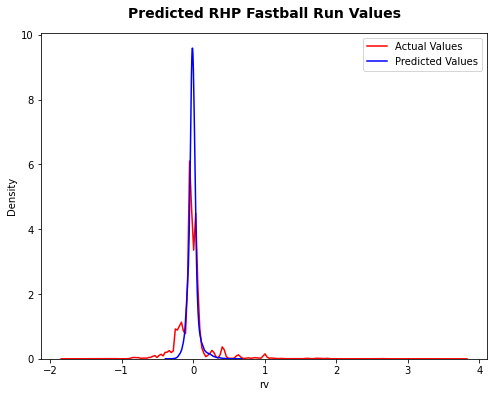

In [7]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV Table

Velocity, Spin Rate, HB, VB, Release Side, Release Height, Release Extension

In [8]:
rhp_fb['n_pitches'] = 1
rhp_fb['xRV'] = pred
rhp_fb['RV/100'] = round(((rhp_fb['rv'] / (rhp_fb['n_pitches'])) * 100), 2)
rhp_fb['xRV/100'] = round(((rhp_fb['xRV'] / (rhp_fb['n_pitches'])) * 100), 2)

grouped_fb_r = rhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_fb_r = rhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension'].mean()
fb_r_rv_table = pd.merge(avg_fb_r, grouped_fb_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

fb_r_rv_table['RV/100'] = round(((fb_r_rv_table['rv'] / (fb_r_rv_table['n_pitches'])) * 100), 2)
fb_r_rv_table['xRV/100'] = round(((fb_r_rv_table['xRV'] / (fb_r_rv_table['n_pitches'])) * 100), 2)

fb_r_rv_table.insert(3, 'n_pitches', fb_r_rv_table.pop('n_pitches'))
fb_r_rv_table = fb_r_rv_table.round(1)
print(fb_r_rv_table.shape)
fb_r_rv_table.head()

(950, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abbott, Cory",R,FF,207,92.6,9.6,17.2,2.6,5.5,6.2,5.7,-0.1,2.7,-0.1
1,"Abreu, Albert",R,FF,103,97.8,11.7,15.4,2.5,5.7,6.4,-1.5,-2.4,-1.5,-2.3
2,"Abreu, Albert",R,SI,212,98.0,15.3,13.3,2.5,5.6,6.5,1.0,-2.9,0.4,-1.4
3,"Abreu, Bryan",R,FF,310,95.7,8.0,17.1,1.5,6.0,6.3,-1.4,-3.4,-0.4,-1.1
4,"Abreu, Bryan",R,SI,2,96.0,14.2,14.9,1.9,5.9,6.4,-0.0,0.0,-1.2,2.0


### RHP Fastball xRV by HB & VB

RHP Fastball Avg RunValue: -0.01
RHP Fastball Avg xRunValue: -0.0


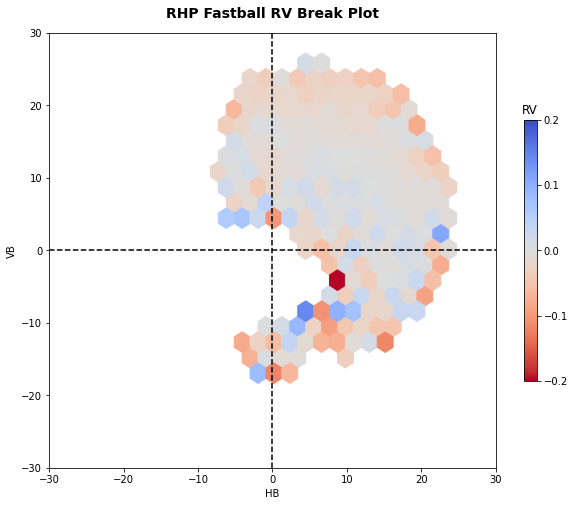

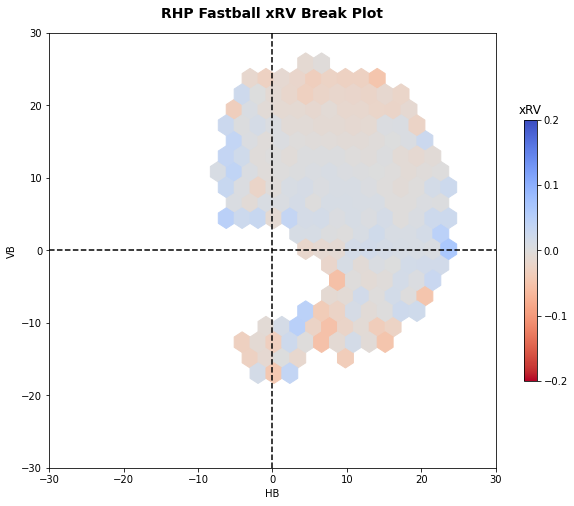

In [10]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['rv'], cmap = 'coolwarm_r', 
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('RV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg RunValue:', round(rhp_fb.rv.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['xRV'], cmap = 'coolwarm_r', 
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg xRunValue:', round(rhp_fb.xRV.mean(), 2))

## Fastball LHP Grouped

#### 4-Seam, Sinker

In [11]:
print('Baseline LHP Fastball RunValue Accuracy Score:', round(lhp_fb.rv.mean(), 2))

Baseline LHP Fastball RunValue Accuracy Score: -0.01


In [12]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['rv'])
y = features_fb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(max_depth = 50, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 1000,
                           n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_fb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.015
Test RMSE: 0.255
Test MAE: 0.134 

R2 Score: 0.327
RMSE: 0.21
MAE: 0.104


### LHP Fastball Actual & Predicted Values

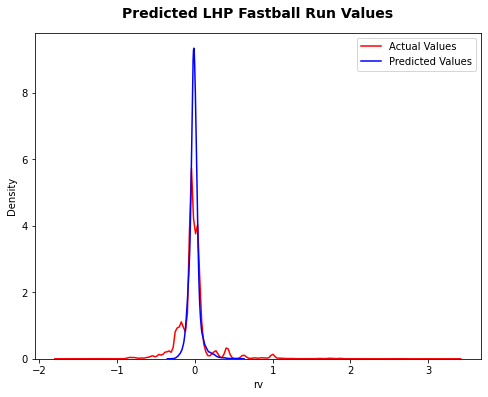

In [13]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV Table

In [14]:
lhp_fb['n_pitches'] = 1
lhp_fb['xRV'] = pred
lhp_fb['RV/100'] = round(((lhp_fb['rv'] / (lhp_fb['n_pitches'])) * 100), 2)
lhp_fb['xRV/100'] = round(((lhp_fb['xRV'] / (lhp_fb['n_pitches'])) * 100), 2)
grouped_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension'].mean()
fb_l_rv_table = pd.merge(avg_fb_l, grouped_fb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

fb_l_rv_table['RV/100'] = round(((fb_l_rv_table['rv'] / (fb_l_rv_table['n_pitches'])) * 100), 2)
fb_l_rv_table['xRV/100'] = round(((fb_l_rv_table['xRV'] / (fb_l_rv_table['n_pitches'])) * 100), 2)

fb_l_rv_table.insert(3, 'n_pitches', fb_l_rv_table.pop('n_pitches'))
fb_l_rv_table = fb_l_rv_table.round(1)
print(fb_l_rv_table.shape)
fb_l_rv_table.head()

(362, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abad, Fernando",L,FF,18,91.7,-5.3,16.2,-0.5,6.2,5.9,2.8,0.9,15.7,5.0
1,"Abad, Fernando",L,SI,141,92.4,-13.2,12.9,-0.6,6.3,5.8,-3.0,1.5,-2.1,1.1
2,"Aguilar, Miguel",L,FF,62,91.4,-4.8,15.7,-0.9,5.5,6.0,-0.8,-1.2,-1.4,-2.0
3,"Akin, Keegan",L,FF,1009,92.0,-10.7,18.1,-2.4,5.9,5.9,-25.3,-21.0,-2.5,-2.1
4,"Albers, Andrew",L,FF,116,88.4,-7.5,18.8,-2.0,5.8,6.2,1.5,-1.7,1.3,-1.4


### LHP Fastball xRV by HB & VB

LHP Fastball Avg RV: -0.01
LHP Fastball Avg xRunValue: -0.01


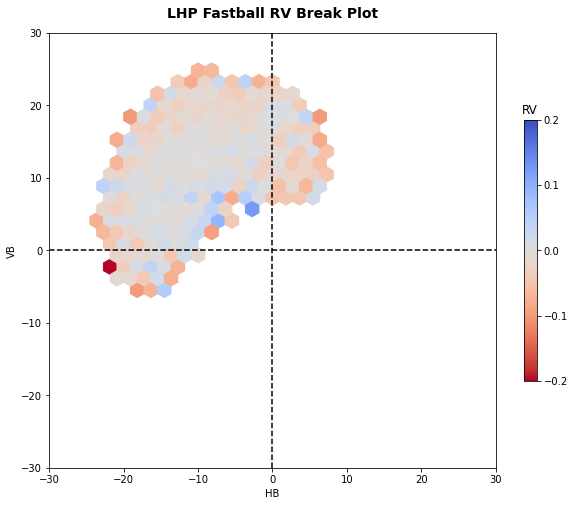

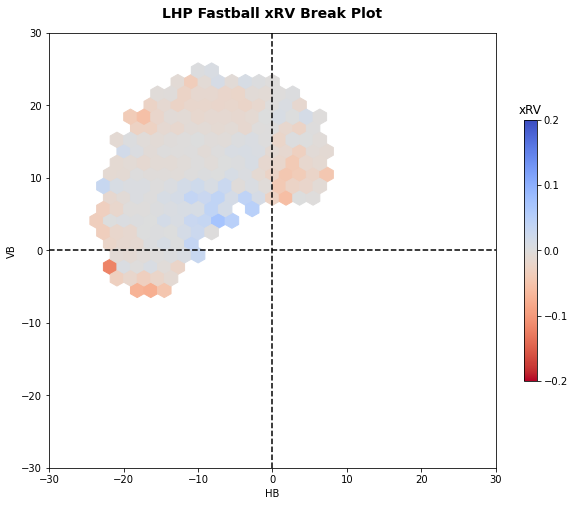

In [15]:
plt.figure(figsize = (10, 8))
plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['rv'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('RV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Fastball Avg RV:', round(lhp_fb.rv.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Fastball Avg xRunValue:', round(lhp_fb.xRV.mean(), 2))

## Breaking Ball RHP

#### Slider, Cutter, Curveball, Knuckle Curve

In [16]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_bb.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.02


In [17]:
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(max_depth = 50, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 1000,
                           n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.013
Test RMSE: 0.257
MAE: 0.133 

R2 Score: 0.321
Test RMSE: 0.21
MAE: 0.101


### RHP Breaking Ball Actual & Predicted Values

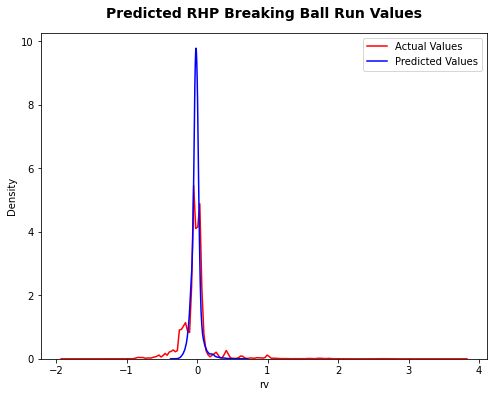

In [18]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV Table

In [19]:
rhp_bb['n_pitches'] = 1
rhp_bb['xRV'] = pred
rhp_bb['RV/100'] = round(((rhp_bb['rv'] / (rhp_bb['n_pitches'])) * 100), 2)
rhp_bb['xRV/100'] = round(((rhp_bb['xRV'] / (rhp_bb['n_pitches'])) * 100), 2)

grouped_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension'].mean()
bb_r_rv_table = pd.merge(avg_bb_r, grouped_bb_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

bb_r_rv_table['RV/100'] = round(((bb_r_rv_table['rv'] / (bb_r_rv_table['n_pitches'])) * 100), 2)
bb_r_rv_table['xRV/100'] = round(((bb_r_rv_table['xRV'] / (bb_r_rv_table['n_pitches'])) * 100), 2)

bb_r_rv_table.insert(3, 'n_pitches', bb_r_rv_table.pop('n_pitches'))
bb_r_rv_table = bb_r_rv_table.round(1)
print(bb_r_rv_table.shape)
bb_r_rv_table.head()

(1065, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abbott, Cory",R,CU,58,84.1,-5.6,-9.9,2.7,5.8,5.9,-4.1,-2.5,-7.1,-4.4
1,"Abbott, Cory",R,SL,63,87.7,6.6,3.5,2.7,5.7,6.0,1.5,2.7,2.4,4.4
2,"Abreu, Albert",R,CU,1,81.0,-9.5,-13.9,2.5,5.8,6.5,0.0,-0.0,2.4,-2.5
3,"Abreu, Albert",R,SL,224,87.3,-2.8,3.5,2.6,5.7,6.3,-4.3,-4.0,-1.9,-1.8
4,"Abreu, Bryan",R,CU,121,86.5,-7.5,-10.0,1.6,6.1,6.1,2.1,-3.6,1.8,-3.0


### RHP Breaking Ball xRV by HB & VB

RHP Breaking Ball Avg RunValue: -0.02
RHP Breaking Ball Avg xRunValue: -0.01


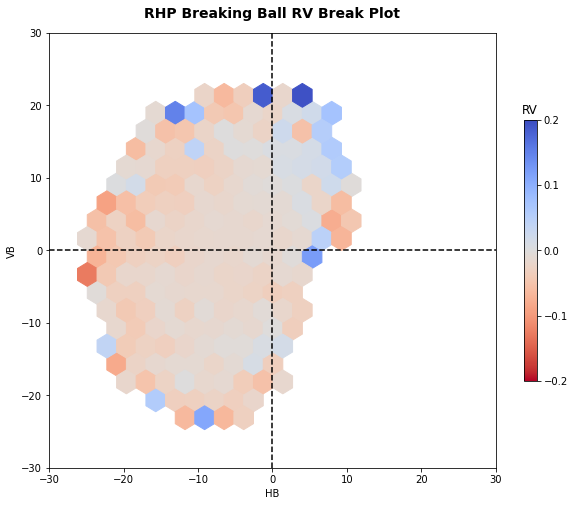

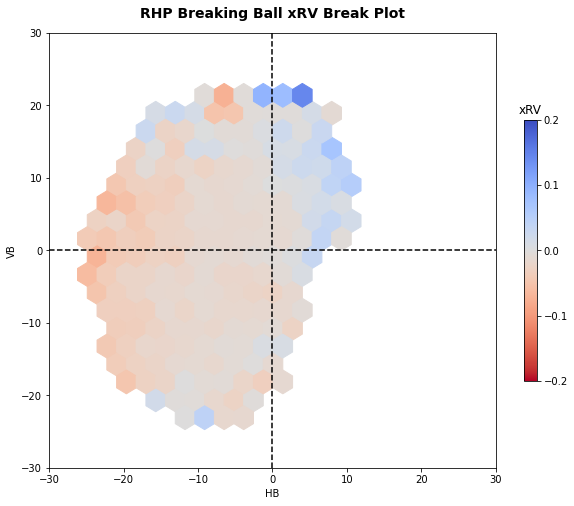

In [20]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['rv'],cmap='coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('RV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg RunValue:', round(rhp_bb.rv.mean(), 2))

plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['xRV'],cmap='coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg xRunValue:', round(rhp_bb.xRV.mean(), 2))

## Breaking Ball LHP
#### Slider, Cutter, Curveball, Knuckle Curve

In [21]:
print('Baseline LHP Breaking Ball RunValue Accuracy Score:', round(lhp_bb.rv.mean(), 2))

Baseline LHP Breaking Ball RunValue Accuracy Score: -0.02


In [22]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(max_depth = 50, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 1000,
                           n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_bb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.019
Test RMSE: 0.26
Test MAE: 0.136 

R2 Score: 0.317
RMSE: 0.211
MAE: 0.103


### LHP Breaking Ball Actual & Predicted Values

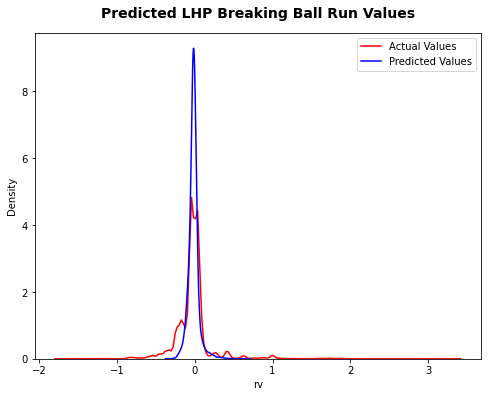

In [23]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV Table

In [24]:
lhp_bb['n_pitches'] = 1
lhp_bb['xRV'] = pred
lhp_bb['RV/100'] = round(((lhp_bb['rv'] / (lhp_bb['n_pitches'])) * 100), 2)
lhp_bb['xRV/100'] = round(((lhp_bb['xRV'] / (lhp_bb['n_pitches'])) * 100), 2)
grouped_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension'].mean()
bb_l_rv_table = pd.merge(avg_bb_l, grouped_bb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

bb_l_rv_table['RV/100'] = round(((bb_l_rv_table['rv'] / (bb_l_rv_table['n_pitches'])) * 100), 2)
bb_l_rv_table['xRV/100'] = round(((bb_l_rv_table['xRV'] / (bb_l_rv_table['n_pitches'])) * 100), 2)

bb_l_rv_table.insert(3, 'n_pitches', bb_l_rv_table.pop('n_pitches'))
bb_l_rv_table = bb_l_rv_table.round(1)
print(bb_l_rv_table.shape)
bb_l_rv_table.head()

(384, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abad, Fernando",L,FC,16,82.6,3.4,2.7,-1.1,6.0,5.9,0.2,-0.5,1.0,-3.2
1,"Abad, Fernando",L,KC,78,76.4,7.2,-9.2,-0.7,6.3,5.6,1.3,0.2,1.7,0.3
2,"Aguilar, Miguel",L,CU,19,80.4,14.2,5.7,-1.2,5.3,5.9,-2.7,-1.7,-14.4,-8.7
3,"Aguilar, Miguel",L,SL,20,85.9,5.3,5.2,-1.1,5.4,6.0,1.7,0.7,8.5,3.4
4,"Akin, Keegan",L,CU,69,76.5,6.0,-4.1,-2.5,5.7,5.9,1.0,0.6,1.4,0.9


### LHP Breaking Ball xRV by HB & VB

LHP Breaking Ball Avg RunValue: -0.02
LHP Breaking Ball Avg xRunValue: -0.02


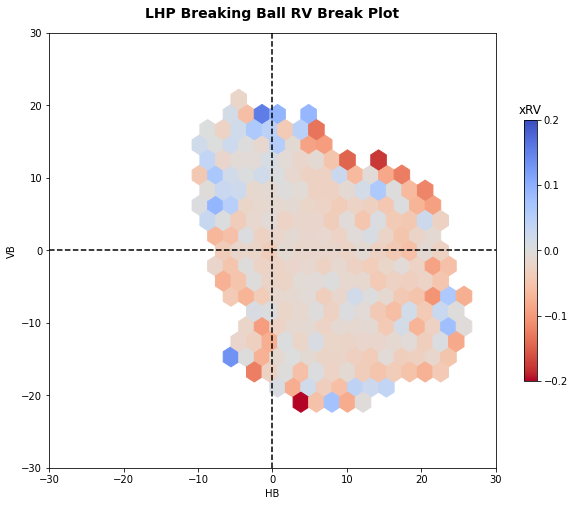

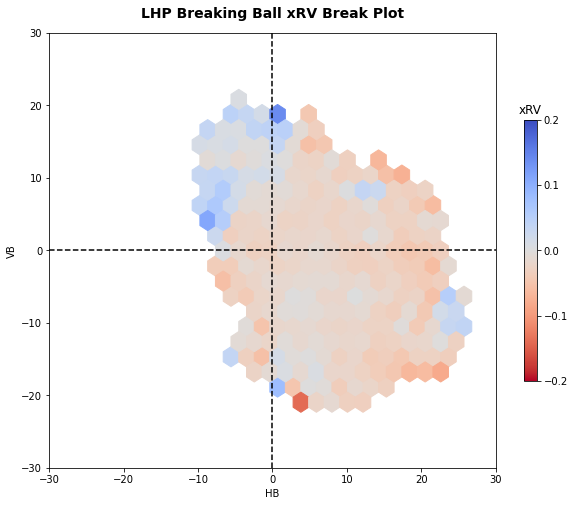

In [25]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['rv'],cmap='coolwarm_r', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avg RunValue:', round(lhp_bb.rv.mean(), 2))

plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['xRV'],cmap='coolwarm_r', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avg xRunValue:', round(lhp_bb.xRV.mean(), 2))

## Off-Speed RHP

#### Changeup, Splitter

In [26]:
print('Baseline RHP Off-Speed RunValue Accuracy Score:', round(rhp_os.rv.mean(), 2))

Baseline RHP Off-Speed RunValue Accuracy Score: -0.01


In [27]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(max_depth = 50, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 1000,
                           n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.015
Test RMSE: 0.262
Test MAE: 0.14 

R2 Score: 0.33
RMSE: 0.212
MAE: 0.107


### RHP Off-Speed Actual & Predicted Run Values

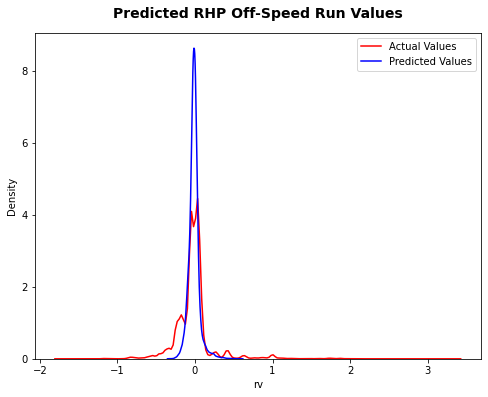

In [28]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off-Speed RV Table

In [29]:
rhp_os['n_pitches'] = 1
rhp_os['xRV'] = pred
rhp_os['RV/100'] = round(((rhp_os['rv'] / (rhp_os['n_pitches'])) * 100), 2)
rhp_os['xRV/100'] = round(((rhp_os['xRV'] / (rhp_os['n_pitches'])) * 100), 2)

grouped_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension'].mean()
os_r_rv_table = pd.merge(avg_os_r, grouped_os_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

os_r_rv_table['RV/100'] = round(((os_r_rv_table['rv'] / (os_r_rv_table['n_pitches'])) * 100), 2)
os_r_rv_table['xRV/100'] = round(((os_r_rv_table['xRV'] / (os_r_rv_table['n_pitches'])) * 100), 2)

os_r_rv_table.insert(3, 'n_pitches', os_r_rv_table.pop('n_pitches'))
os_r_rv_table = os_r_rv_table.round(1)
print(os_r_rv_table.shape)
os_r_rv_table.head()

(522, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abbott, Cory",R,CH,23,87.0,13.9,12.3,2.4,5.7,6.1,-0.7,-0.1,-2.9,-0.3
1,"Abreu, Albert",R,CH,102,88.2,16.8,8.6,2.3,5.7,6.5,2.1,-1.4,2.0,-1.4
2,"Acevedo, Domingo",R,CH,37,86.0,16.9,8.7,1.5,6.0,6.0,-2.8,-1.1,-7.6,-3.0
3,"Adam, Jason",R,CH,22,87.2,15.8,2.7,1.9,6.0,6.6,0.5,-0.2,2.5,-0.8
4,"Adon, Joan",R,CH,6,87.1,16.8,9.3,2.9,6.0,6.2,-0.0,-0.0,-0.7,-0.2


### RHP Off-Speed xRV by HB & VB

RHP Off-Speed Avg RunValue: -0.01
RHP Off-Speed Avg xRunValue: -0.01


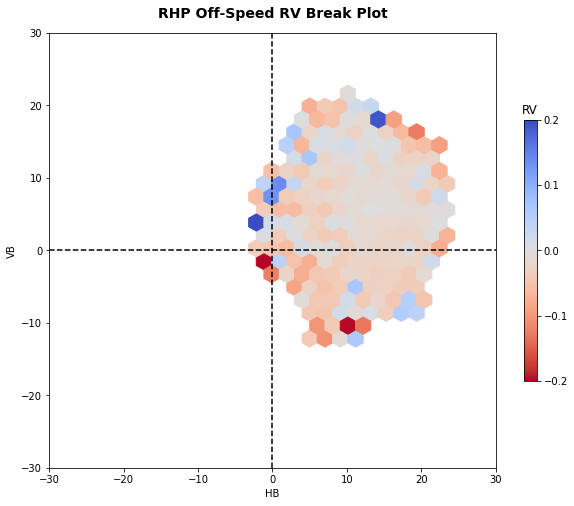

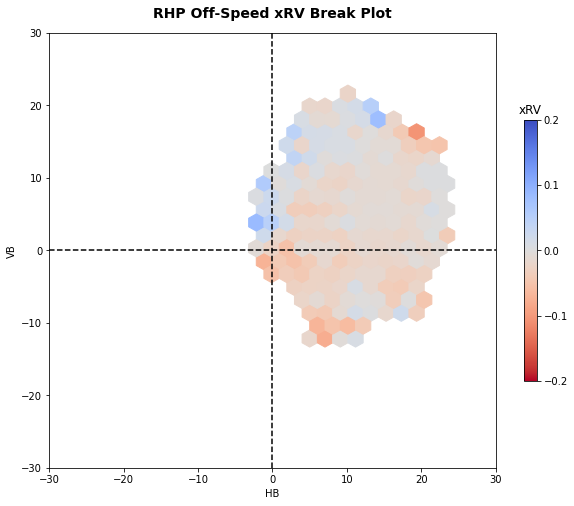

In [30]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['rv'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('RV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg RunValue:', round(rhp_os.rv.mean(), 2))

plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg xRunValue:', round(rhp_os.xRV.mean(), 2))

## Off-speed LHP
#### Changeup, Splitter

In [31]:
print('Baseline LHP Off-Speed RunValue Accuracy Score:', round(lhp_os.rv.mean(), 2))

Baseline LHP Off-Speed RunValue Accuracy Score: -0.01


In [32]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(max_depth = 50, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 1000,
                           n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_os_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.022
Test RMSE: 0.267
Test MAE: 0.143 

R2 Score: 0.324
RMSE: 0.218
MAE: 0.11


### LHP Off-Speed Actual & Predicted Values

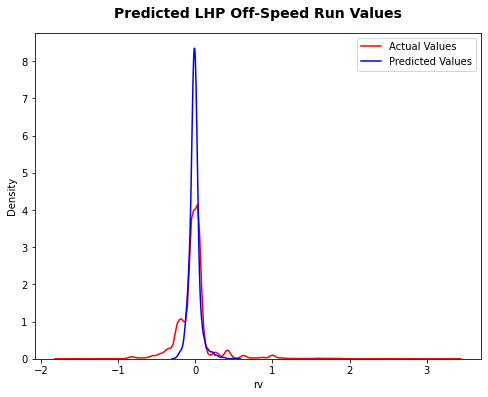

In [33]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed RV Table

In [34]:
lhp_os['n_pitches'] = 1
lhp_os['xRV'] = pred
lhp_os['RV/100'] = round(((lhp_os['rv'] / (lhp_os['n_pitches'])) * 100), 2)
lhp_os['xRV/100'] = round(((lhp_os['xRV'] / (lhp_os['n_pitches'])) * 100), 2)
grouped_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension'].mean()
os_l_rv_table = pd.merge(avg_os_l, grouped_os_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

os_l_rv_table['RV/100'] = round(((os_l_rv_table['rv'] / (os_l_rv_table['n_pitches'])) * 100), 2)
os_l_rv_table['xRV/100'] = round(((os_l_rv_table['xRV'] / (os_l_rv_table['n_pitches'])) * 100), 2)

os_l_rv_table.insert(3, 'n_pitches', os_l_rv_table.pop('n_pitches'))
os_l_rv_table = os_l_rv_table.round(1)
print(os_l_rv_table.shape)
os_l_rv_table.head()

(186, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abad, Fernando",L,CH,46,75.1,-10.7,14.2,-0.7,6.4,5.9,-2.3,-0.1,-5.0,-0.3
1,"Aguilar, Miguel",L,CH,3,85.8,-14.9,8.9,-1.0,5.3,6.1,0.0,0.1,1.5,1.9
2,"Akin, Keegan",L,CH,344,81.9,-15.3,8.4,-2.5,5.7,6.0,6.2,0.6,1.8,0.2
3,"Albers, Andrew",L,CH,53,80.0,-12.7,7.7,-2.2,5.9,6.1,-0.9,-0.6,-1.8,-1.1
4,"Alexander, Scott",L,CH,22,86.2,-13.6,4.5,-1.8,5.7,6.1,-0.3,-0.5,-1.4,-2.1


### LHP Off-Speed xRV by HB & VB

LHP Off-Speed Avg RunValue: -0.01
LHP Off-Speed Avg xRunValue: -0.01


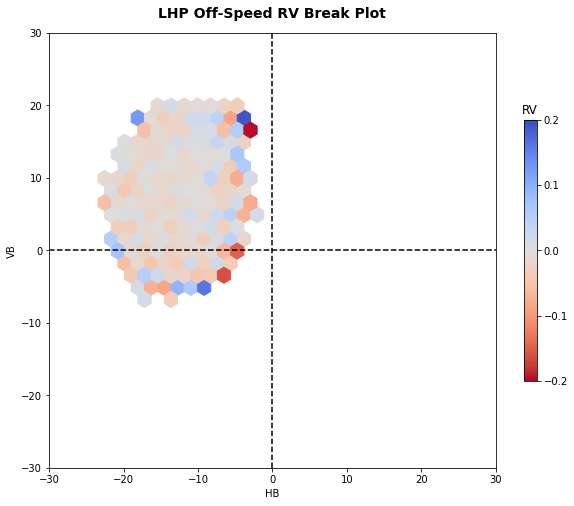

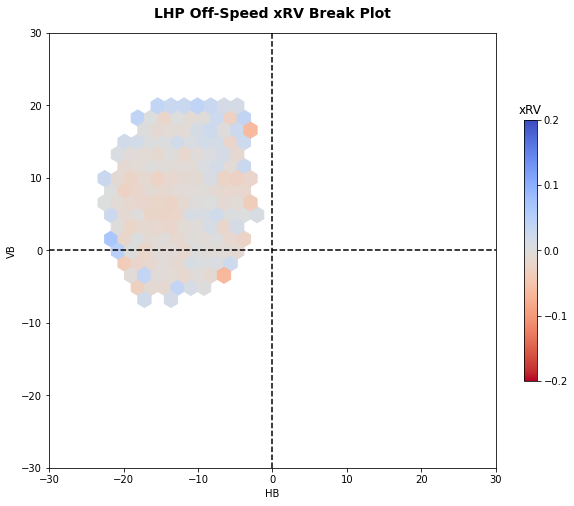

In [35]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['rv'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('RV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Off-Speed Avg RunValue:', round(lhp_os.rv.mean(), 2))

plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Off-Speed Avg xRunValue:', round(lhp_os.xRV.mean(), 2))

## Save Grouped RV Tables to CSV

In [36]:
xrv_grouped = pd.concat([rhp_fb, lhp_fb, rhp_bb, lhp_bb, rhp_os, lhp_os], ignore_index = True)
xrv_grouped.fillna(0, inplace = True)
#xrv_grouped.to_csv('../data/xrv_grouped.csv')

rv_table = pd.concat([fb_r_rv_table, fb_l_rv_table, bb_r_rv_table, bb_l_rv_table, os_r_rv_table, os_l_rv_table])
#rv_table.to_csv('../data/rv_table.csv')